
# Text Classification via Logistic Regresssion 

This homework notebook has been adapted from the PyTorch tutorial [Text Classification with the TorchText Library](https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html).

[Torchtext](https://pytorch.org/text/stable/index.html) is a library within the PyTorch framework that consists of data processing utilities and popular datasets for natural language processing.

In this homework, we will
- build a logistic regression model for text classification using bag of words (BoW).
- extend the above model to use continuous bag of words (CBoW).
- consider some other extensions, such as using a better version of gradient descent.

You have to complete **13 tasks**, specified at appropriate places, worth a total of 35 points.


## Classes Dataset and DataLoader

Dataset and DataLoader are PyTorch classes that provides utilities for iterating through and sampling from a dataset. They provide several features for advanced applications (e.g., skim through [this tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) on writing custom datasets and dataloaders).

We'll work with the `` AG_NEWS`` dataset included within torchtext, and will write a custom dataloader to create minibatches of examples for training and testing.  The [``AG_NEWS``](https://rdrr.io/cran/textdata/man/dataset_ag_news.html) consists of about 120,000 examples of text from news sources, each labeled with one of 4 classes (world, sports, business, science and technology). 

In [330]:
import torch
from torchtext.datasets import AG_NEWS
train_data = AG_NEWS(split='train')

A dataset behaves like an iterator.  So when called in a for loop or using next it returns a sequence of examples, each of which is a pair of label and text.

In [331]:
example1 = next(train_data)
example1

(3,
 "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.")

In [332]:
next(train_data)

(3,
 'Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\\which has a reputation for making well-timed and occasionally\\controversial plays in the defense industry, has quietly placed\\its bets on another part of the market.')

In [333]:
next(train_data)

(3,
 "Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\\about the economy and the outlook for earnings are expected to\\hang over the stock market next week during the depth of the\\summer doldrums.")

## Preprocessing: tokenizing, converting to BoW


In order to convert a piece of text into, say, a BoW vector, we need to do

- Split up the text into a sequence of words or tokens.  This can be a suprisingly complex task because of various uses of apostrophe, uses of contractions, etc.  (E.g., see this [article](https://nlp.stanford.edu/IR-book/html/htmledition/tokenization-1.html) at Stanford.)  We'll simply use a tokenizer provided by torchtext.

- Determine which tokens will be included in our BoW vector, and which will be ignored.  Using too few will degrade prediction performance, while using too many will slow down the system.  We'll only include words that occur in the training set at least a given minimum number of times.

- Convert each included word into an numerical index corresponding to its position on the BoW vectors. Torchtext provide a ``Vocab`` class to help with this. (Alternately, we can convert each word into a dense vector representation using pretrained representations such as [GloVe](https://nlp.stanford.edu/projects/glove/).) 

In [334]:
from torchtext.data.utils import get_tokenizer # "we'll simply use a tokenizer provided by torchtext"
from collections import Counter  # dict subclass for counting hashable objects
from torchtext.vocab import Vocab

tokenizer = get_tokenizer('basic_english') # tokenizer provided by torchtext
train_iter = AG_NEWS(split='train') # dataset provided by torchtext
counter = Counter()  # dict subclass for counting hashable objects
for (label, line) in train_iter:
    counter.update(tokenizer(line))
# Only inlcude words that occur at least 1000 times in the training data.
vocab = Vocab(counter, min_freq=1000)



``vocab`` can be used to convert a list of tokens in a list of indices.

In [335]:
[vocab[token] for token in ['here', 'is', 'an', 'example']]

[476, 22, 31, 0]

See the [documentation](https://pytorch.org/text/stable/vocab.html) for ``Vocab.``  Now write code to answer the following:
- **Task 1** [1 points]: Print the number of words in ``vocab``.
- **Task 2** [1]: Print the index of the word "economy".
- **Task 3** [1]: Print the word at index 500.
- **Task 4** [1]: Write code to determine the index associated with words not in the vocabulary. What is that index value?

In [336]:
### WRITE YOUR CODE BELOW
print("The length of the vocab, two different ways: ",
      vocab.__len__(), ",", len(vocab))
print("The index of the token, economy, two different ways: ",
      vocab.__getitem__("economy"), ",", vocab["economy"])
print("The word at index 500: ", vocab.itos[500])

def determine_index(token):
      '''
      Sets index of unknown token that is outside of vocabulary to 0, which corresponds to "<unk>".
      '''
      if not vocab[token]:
            print(f"{token} is unknown/outside of the vocabulary")
            return vocab["<unk>"]
      else:
            return vocab[token]

print("The index of the token, party: ", determine_index("party"))
print("The index of the token, partyy: ", determine_index("partyy"))


The length of the vocab, two different ways:  633 , 633
The index of the token, economy, two different ways:  348 , 348
The word at index 500:  party
The index of the token, party:  500
partyy is unknown/outside of the vocabulary
The index of the token, partyy:  0


A [dataloader](https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader) takes a dataset and creates minibatches of examples, each of a specified batch size.  We specify how it processes each example from the dataset via a custom collate function.

**Task 5** [5]: Write a collate function ``collate_into_bow`` that accepts a batch of k examples created from the dataset above and returns two tensors:
a tensor of shape (k,) containing the labels of the batch, and a tensor of shape (k, m), in which m is the number of tokens in the vocabulary, containing the bow vectors for the examples. Further:

1. The labels in the dataset are numbers 1 to 4. Since PyTorch is 0-indexed, please convert them to numbers 0 to 3 in the collate function.
2. Remember that the entry in each bow vector is the **relative frequency** of the word in the corresponding text.

In [337]:
from torch.utils.data import DataLoader

def collate_into_bow(batch):
    
## WRITE YOUR CODE BELOW    
    labels = []
    words_lst = []
    for (label, words) in batch:
        labels.append(int(label) - 1)
        word_occurrence = Counter(words.split()) # count occurences for each word in example
        words_lst.append(word_occurrence) 
    labels = torch.tensor(labels)

    bow_vector = torch.zeros(len(words_lst), len(vocab))  # initiate bow vector of size (k, m)
    for i in range(len(words_lst)):
        for key, value in words_lst[i].items():
            # replace ith example row and vocab index column with word occurence percentage
            bow_vector[i, vocab[key]] = value/len(words_lst)

    return labels, bow_vector


def test_collate():
    w1 = vocab.itos[3]
    w2 = vocab.itos[7]
    w3 = vocab.itos[8]
    w4 = vocab.itos[9]
    examples = [
        (1, " ".join([w1, w2, w3, w4])),
        (2, " ".join([w2, w1, w3, w4])),
        (4, " ".join([w4, w2, w3, w4])),
        (3, " ".join([w2, w2, w2, w4])),
    ]
    bowt = torch.tensor(
        [
            [0.0, 0.0, 0.0, 0.25, 0.0, 0.0, 0.0, 0.25, 0.25, 0.25],
            [0.0, 0.0, 0.0, 0.25, 0.0, 0.0, 0.0, 0.25, 0.25, 0.25],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 0.25, 0.50],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.75, 0.0, 0.25],
        ]) 
    lt, tt = collate_into_bow(examples)
    assert torch.equal(lt, torch.tensor([0, 1, 3, 2]))
    assert torch.equal(tt[:,:10], bowt)
    assert tt[:,10:].sum().item() == 0.00
    print('Test passed.')
    
test_collate()


Test passed.


The collate function is provided to a dataloader as shown below.

In [338]:
train_iter = AG_NEWS(split='train')
dataloader = DataLoader(train_iter, batch_size=16, shuffle=False, 
                        collate_fn=collate_into_bow)
for idx, (lt, tt) in enumerate(dataloader):
    print(idx, lt.shape, tt.shape)
    if idx == 4: break

0 torch.Size([16]) torch.Size([16, 633])
1 torch.Size([16]) torch.Size([16, 633])
2 torch.Size([16]) torch.Size([16, 633])
3 torch.Size([16]) torch.Size([16, 633])
4 torch.Size([16]) torch.Size([16, 633])


## A BoW Classifier Class

**Task 6** [3]: Write a BoWClassifier class with one single linear layer,
similar to the one in [Robert Guthrie's tutorial](https://pytorch.org/tutorials/beginner/nlp/deep_learning_tutorial.html#sphx-glr-beginner-nlp-deep-learning-tutorial-py).


In [339]:
from torch import nn
import torch.nn.functional as F

class BoWClassifier(nn.Module):
    
## WRITE YOUR CODE BELOW
    def __init__(self, num_labels, vocab_size):
        # calls the init function of nn.Module.  Dont get confused by syntax,
        # just always do it in an nn.Module
        super(BoWClassifier, self).__init__()
        self.linear = nn.Linear(in_features=vocab_size,
                                out_features=num_labels)

    def forward(self, bow_vec):
        # Pass the input through the linear layer - then through log_softmax.
        return F.log_softmax(self.linear(bow_vec), dim=1)


The following creates a model object of the class BoWClassifier.




In [340]:
train_data = AG_NEWS(split='train')
num_labels = len(set([label for (label, text) in train_iter]))
vocab_size = len(vocab)
model = BoWClassifier(num_labels, vocab_size)

## Training an epoch

The code below is similar to what we saw in Gutherie's tutorial. It prints the loss every 500 iterations. ``model.train()`` is used by PyTorch to set the model in training model.  This usually only impacts some advanced architectures.

In [341]:
import time

loss_function = torch.nn.NLLLoss()

def train_an_epoch(dataloader):
    model.train() # Sets the module in training mode.
    log_interval = 500

    for idx, (label, text) in enumerate(dataloader):
        model.zero_grad()
        log_probs = model(text)
        loss = loss_function(log_probs, label)
        loss.backward()
        optimizer.step()
        if idx % log_interval == 0 and idx > 0:
            print(f'At iteration {idx} the loss is {loss:.3f}.')

## Computing average accuracy on a validation set

**Task 7** [3]: Write a function ``get_accuracy`` to compute the average accuracy of the model for a given dataloader.  Your code should iterate through all the examples, for each find the predicted label with the highest probability, and count the number of examples in which this predicted label is correct.  It should then return the average accuracy. Remember that although most batches will have a fixed number of examples (the given batch size), the last batch may have fewer examples.  So you should explicitly count the number of examples in each batch.

In [342]:
def get_accuracy(dataloader):
    model.eval()
    with torch.no_grad():
    ## WRITE YOUR CODE BELOW.    
        total_acc, total_count = 0, 0
        for idx, (label, word_idxs) in enumerate(dataloader):
            log_probs = model(word_idxs)
            total_acc += (log_probs.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count


## Create training, validation, and testing dataloaders

Since the original ``AG_NEWS`` has no valid dataset, we split the training
dataset into train/valid sets with a split ratio of 0.95 (train) and
0.05 (valid). Here we use
[``torch.utils.data.dataset.random_split``](https://pytorch.org/docs/stable/data.html?highlight=random_split#torch.utils.data.random_split)
function in PyTorch core library.

In [343]:
from torch.utils.data.dataset import random_split

BATCH_SIZE = 64 # batch size for training
  
train_valid_data, test_data = AG_NEWS()
train_valid_data = list(train_valid_data)
num_train = int(len(train_valid_data) * 0.95)
num_valid = len(train_valid_data) - num_train
train_data, valid_data = random_split(
    train_valid_data, [num_train, num_valid])

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE,
                              shuffle=True, 
                              collate_fn=collate_into_bow)
valid_dataloader = DataLoader(valid_data, batch_size=BATCH_SIZE,
                              shuffle=False, 
                              collate_fn=collate_into_bow)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE,
                             shuffle=False, 
                             collate_fn=collate_into_bow)

## Training

At iteration 500 the loss is 1.406.
At iteration 1000 the loss is 1.423.
At iteration 1500 the loss is 1.353.

After epoch 1 the validation accuracy is 0.366.

At iteration 500 the loss is 1.300.
At iteration 1000 the loss is 1.275.
At iteration 1500 the loss is 1.267.

After epoch 2 the validation accuracy is 0.382.

At iteration 500 the loss is 1.319.
At iteration 1000 the loss is 1.216.
At iteration 1500 the loss is 1.289.

After epoch 3 the validation accuracy is 0.484.

At iteration 500 the loss is 1.223.
At iteration 1000 the loss is 1.252.
At iteration 1500 the loss is 1.286.

After epoch 4 the validation accuracy is 0.390.

At iteration 500 the loss is 1.157.
At iteration 1000 the loss is 1.200.
At iteration 1500 the loss is 1.141.

After epoch 5 the validation accuracy is 0.265.

At iteration 500 the loss is 1.157.
At iteration 1000 the loss is 1.234.
At iteration 1500 the loss is 1.143.

After epoch 6 the validation accuracy is 0.507.

At iteration 500 the loss is 1.172.
At i

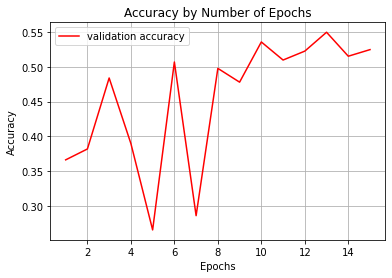

In [344]:
import matplotlib.pyplot as plt
%matplotlib inline

EPOCHS = 10 # epoch 
optimizer = torch.optim.SGD(model.parameters(), lr=3)

validation_accuracies = []
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train_an_epoch(train_dataloader)
    validation_accuracy = get_accuracy(valid_dataloader)
    validation_accuracies.append(validation_accuracy)
    time_taken = time.time() - epoch_start_time
    print()
    print(
        f'After epoch {epoch} the validation accuracy is {validation_accuracy:.3f}.')
    print()

plt.title("Accuracy by Number of Epochs")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.grid()
plt.plot(range(1, EPOCHS+1), validation_accuracies, "r", label="validation accuracy")
plt.legend()
plt.savefig(f"Accuracy{EPOCHS}epochs.jpg")


**Task 8** [5]: Run the model for a sufficient number of epochs such that the model shows overfitting, and submit a pdf of the plot of accuracy against number of epochs.  Determine the optimal number of epochs to train for.  Write code to estimate the accuracy of your model corresponding to this optimal number of epocs and report this estimated accuracy.

**Task 9** [2]: Notice above that both the printed losses and the accuracies keep varying and do not necessary increase or decrease in a steady fashion.  List all the reasons you can think of for this variance in the loss and the accuracy.

In [345]:
'''
Task 8: Determine the optimal number of epochs to train for.
We can see from the graph that the accuracy increases rapidly until just before 10 epochs, 
at which point the accuracy continues to increases slow and steadily. For the sake of time, 
10 epochs should be enough time to capture the spike in accuracy, while not being too long to 
get just a few percentage points higher.

Task 9: This high variability may be caused by a learning rate that is too high. 
This is a gradient decent algorithm, and the gradient should to converge to zero with ideal parameters.
Currently the learning rate is set to 3, and perhaps the model is overcorrecting the bottom of the loss curve each time.
I would try reducing the learning rate to something that more easily converges to zero without taking too much longer to compute.
'''


'\nTask 8: Determine the optimal number of epochs to train for.\nWe can see from the graph that the accuracy increases rapidly until just before 10 epochs, \nat which point the accuracy continues to increases slow and steadily. For the sake of time, \n10 epochs should be enough time to capture the spike in accuracy, while not being too long to \nget just a few percentage points higher.\n\nTask 9: This high variability may be caused by a learning rate that is too high. \nThis is a gradient decent algorithm, and the gradient should to converge to zero with ideal parameters.\nCurrently the learning rate is set to 3, and perhaps the model is overcorrecting the bottom of the loss curve each time.\nI would try reducing the learning rate to something that more easily converges to zero without taking too much longer to compute.\n'

## Adding a pre-trained embedding

[GloVe](https://nlp.stanford.edu/projects/glove/) is set of dense vector representations, or embeddings.  Torchtext has support for GloVe. (It takes several minutes the first time---to download.)

In [346]:
from itertools import combinations
from torchtext.vocab import GloVe

glove = GloVe(name='6B')  # global vectors

words = ["hello", "hi", "king", "president"]
vecs = glove.get_vecs_by_tokens(words)

print(vecs.shape)
print()
for (i, j) in combinations(range(4), 2):
    print(words[i], words[j], vecs[i].dot(vecs[j]))
print()
print(vecs)

torch.Size([4, 300])

hello hi tensor(13.7214)
hello king tensor(2.2427)
hello president tensor(2.7678)
hi king tensor(1.4366)
hi president tensor(-2.7832)
king president tensor(14.2624)

tensor([[-0.3371, -0.2169, -0.0066,  ...,  0.4056,  0.1807,  0.6425],
        [ 0.4084, -0.1843, -0.1757,  ..., -0.5265,  0.8163,  0.7427],
        [ 0.0034, -0.3461,  0.2814,  ...,  0.0821, -0.6880,  0.3027],
        [ 0.4367,  0.1879, -0.1702,  ...,  0.0329, -0.5214,  0.2229]])


**Task 10** [5]: Write a new collate function ``collate_into_cbow`` that returns a CBoW representation of each batch, using GloVe.

**Task 11** [2]: Write copies of other functions as needed to determine the estimate accuracy of the (optimal) model that incorporates GloVe.

In [347]:
def collate_into_cbow(batch):
    '''
    Input:
    A batch (list) containing single strings of words separated by spaces (sentence strings).

    Returns
        1. A tensor of labels for each of the sentence in the dataset
        2. A tensor of the vectors representing each of the sentences in the dataset
    '''
    labels = []
    vecs = []
    for (label, words) in batch:
        labels.append(int(label) - 1)
        # average the word embeddings along columns (axis=0)
        # make vecs a list of lists instead of a list of tensors, then make the embedded list a tensor.
        vecs.append(glove.get_vecs_by_tokens(words.split()).mean(dim=0).tolist()) 
    labels = torch.tensor(labels)
    vecs = torch.tensor(vecs)
    return labels, vecs



In [348]:
dataloader_continuous = DataLoader(train_iter, batch_size=16, shuffle=False,
                        collate_fn=collate_into_cbow)
for idx, (lt, tt) in enumerate(dataloader_continuous):
    print(idx, lt.shape, tt.shape)
    if idx == 4:
        break


In [349]:
def train_an_epoch_continuous(dataloader_continuous):
    model.train()  # Sets the module in training mode.
    log_interval = 500

    for idx, (label, text) in enumerate(dataloader_continuous):
        model.zero_grad()
        log_probs = model(text)
        loss = loss_function(log_probs, label)
        loss.backward()
        optimizer.step()
        if idx % log_interval == 0 and idx > 0:
            print(f'At iteration {idx} the loss is {loss:.3f}.')


In [350]:
def get_Adam_accuracy(dataloader_continuous):
    model.eval()
    with torch.no_grad():
        total_acc, total_count = 0, 0
        for idx, (label, word_idxs) in enumerate(dataloader_continuous):
            log_probs = model(word_idxs)
            total_acc += (log_probs.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count


## Using the Adam optimizer

The [Adam](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam) is usually preferred to SGD because of better convergence properites.

**Task 12** [3]: Write copies of functions as needed to plot the convergence of the Adam optimizer.

At iteration 500 the loss is 1.196.
At iteration 1000 the loss is 1.005.
At iteration 1500 the loss is 1.055.

After epoch 1 the validation accuracy is 0.577.

At iteration 500 the loss is 0.983.
At iteration 1000 the loss is 1.048.
At iteration 1500 the loss is 1.008.

After epoch 2 the validation accuracy is 0.602.

At iteration 500 the loss is 1.032.
At iteration 1000 the loss is 0.975.
At iteration 1500 the loss is 1.033.

After epoch 3 the validation accuracy is 0.609.

At iteration 500 the loss is 1.074.
At iteration 1000 the loss is 1.052.
At iteration 1500 the loss is 1.092.

After epoch 4 the validation accuracy is 0.615.

At iteration 500 the loss is 1.071.
At iteration 1000 the loss is 1.043.
At iteration 1500 the loss is 1.020.

After epoch 5 the validation accuracy is 0.614.

At iteration 500 the loss is 1.042.
At iteration 1000 the loss is 1.014.
At iteration 1500 the loss is 1.020.

After epoch 6 the validation accuracy is 0.615.

At iteration 500 the loss is 0.940.
At i

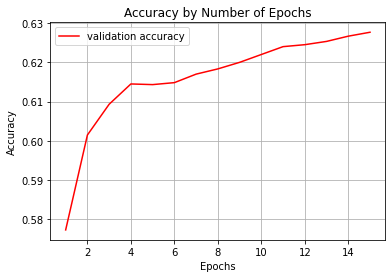

In [351]:
import time
import matplotlib.pyplot as plt
%matplotlib inline

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

validation_accuracies = []
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train_an_epoch_continuous(train_dataloader)
    validation_accuracy = get_Adam_accuracy(valid_dataloader)
    validation_accuracies.append(validation_accuracy)
    time_taken = time.time() - epoch_start_time
    print()
    print(
        f'After epoch {epoch} the validation accuracy is {validation_accuracy:.3f}.')
    print()

plt.title("Accuracy by Number of Epochs")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.grid()
plt.plot(range(1, EPOCHS+1), validation_accuracies,
         "r", label="validation accuracy")
plt.legend()
plt.savefig(f"AdamAccuracy{EPOCHS}epochs.jpg")


## Other Optimizations

**Task 13** [3]: Briefly desribe 3 ways by which you could make the above code run faster or improve its accuracy.  (You don't have to implement your suggestions.)

In [352]:
'''
1. We could increase the number of words in our vocabulary by decreasing the min_freq parameter. 
   This would give us more words in our dataset, which could assist with the accuracy of our model.
2. We could implement k-fold cross validation resampling to optimize the training of our model, 
   which could assist with its accuracy.
3. We could run an ensemble of classifiers in addition to BoW, such as BERT and word2vec, 
   and use the model with the greatest properly-fitted accuracy.
'''


'\n1. We could increase the number of words in our vocabulary by decreasing the min_freq parameter. \n   This would give us more words in our dataset, which could assist with the accuracy of our model.\n2. We could implement k-fold cross validation resampling to optimize the training of our model, \n   which could assist with its accuracy.\n3. We could run an ensemble of classifiers in addition to BoW, such as BERT and word2vec, \n   and use the model with the greatest properly-fitted accuracy.\n'